In [1]:
!nvidia-smi

Sun Nov 28 17:37:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch --branch main https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

In [3]:
from dul_2021.utils.hw2_utils import *

In [4]:
from torch import nn
from torch.utils import data
from torch import optim
from tqdm import tqdm
import torch

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Question 1 PixelCNNs

## Part (a) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

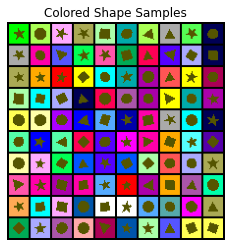

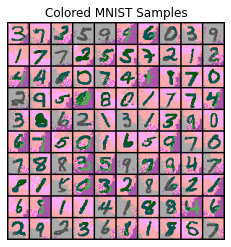

In [ ]:
visualize_q1a_data(1)
visualize_q1a_data(2)
# you can get access to the data with q1ab_get_data

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # x.shape = (N, C, H, W)
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, 
                        stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()

In [ ]:
class ConvA(MaskedConv):
    def set_mask(self): 
        H, W = self.kernel_size
        self.mask[:, :, H // 2, :(W // 2)] = 1
        self.mask[:, :, :(H // 2)] = 1

    
class ConvB(MaskedConv):
    def set_mask(self):
        H, W = self.kernel_size
        self.mask[:, :, H // 2, :(W // 2 + 1)] = 1
        self.mask[:, :, :(H // 2)] = 1

In [ ]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        # x.shape = (N, C, H, W)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super().__init__()
        self.model = nn.Sequential(
            nn.ReLU(), 
            ConvB(in_channels, in_channels // 2, 1, **kwargs), 
            nn.ReLU(), 
            ConvB(in_channels // 2, in_channels // 2, 7, padding=3, **kwargs), 
            nn.ReLU(), 
            ConvB(in_channels // 2, in_channels, 1, **kwargs)
        )
        
    def forward(self, x):
        # x.shape = (N, C, H, W)
        out = self.model(x)
        return out + x

In [ ]:
def collate_fn(x): 
    # x.shape = (N, H, W, C)
    x = np.array(x).transpose(0, 3, 1, 2)
    x = torch.tensor(x, dtype=torch.long)
    return x 

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors,
                 n_filters=120, kernel_size=7):
        super().__init__()
        self.input_shape = input_shape
        self.n_colors = n_colors
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.model = nn.Sequential(*self.get_model())

    def get_model(self): 
        C, H, W = self.input_shape
        model = [ConvA(C, self.n_filters, self.kernel_size, padding=self.kernel_size // 2), 
                 LayerNorm(self.n_filters), 
                 nn.ReLU()]

        for _ in range(8): 
            model.extend([Residual(self.n_filters), LayerNorm(self.n_filters), nn.ReLU()])

        model.extend([ConvB(self.n_filters, self.n_filters, 1), 
                      nn.ReLU(), 
                      ConvB(self.n_filters, C * self.n_colors, 1)])
        
        return model

    def forward(self, x): 
        # x.shape = (N, C, H, W)
        out = self.model(x)
        return out.view(x.shape[0], self.n_colors, *self.input_shape)
        
    def nll(self, x):
        logits = self(x)
        return F.cross_entropy(logits, x.long())

    def test(self, testloader):
        total_loss = counts = 0

        with torch.no_grad():
            for batch in testloader:
                batch = batch.to(device).float()
                total_loss += self.nll(batch) * batch.shape[0]
                counts += batch.shape[0]
        
        return total_loss / counts
                
    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):
        trainloader = data.DataLoader(train_data, batch_size=batch_size, 
                                      shuffle=True, collate_fn=collate_fn)
        testloader = data.DataLoader(test_data, batch_size=batch_size,
                                     collate_fn=collate_fn)

        train_loss = []
        test_loss = []
        optimizer = optim.Adam(self.parameters(), lr=lr)
        test_loss.append(self.test(testloader))

        for epoch in tqdm(range(num_epochs), "Train epoch"):
            for batch in trainloader:
                loss = self.nll(batch.to(device).float())
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optimizer.step()
                train_loss.append(loss.cpu().data)

            test_loss.append(self.test(testloader))
        
        return train_loss, test_loss

    def sample(self, n_samples):
        self.model.eval()
        samples = torch.zeros(n_samples, *self.input_shape).to(device)
        C, H, W = self.input_shape

        with torch.no_grad():
            for x in range(H):
                for y in range(W):
                    for c in range(C): 
                        logits = self(samples)[:, :, c, x, y]
                        probs = F.softmax(logits, dim=1)
                        samples[:, c, x, y] = torch.multinomial(probs, 1).squeeze(-1)
                          
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [ ]:
def q1_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """

  H, W, C = image_shape
  model = PixelCNN((C, H, W), 4, 120, 7).to(device)
  train_loss, test_loss = model.fit(train_data, test_data)
  samples = model.sample(100)
  return train_loss, test_loss, samples

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Train epoch: 100%|██████████| 20/20 [14:45<00:00, 44.28s/it]


Final Test Loss: 0.0402


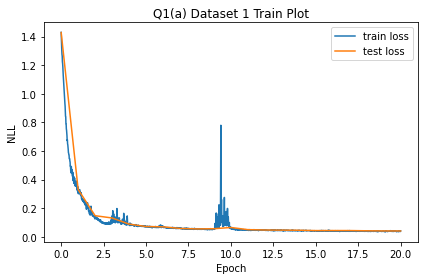

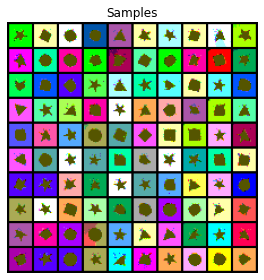

In [ ]:
q1ab_save_results(1, 'a', q1_a)

Train epoch: 100%|██████████| 20/20 [2:40:15<00:00, 480.79s/it]


Final Test Loss: 0.0787


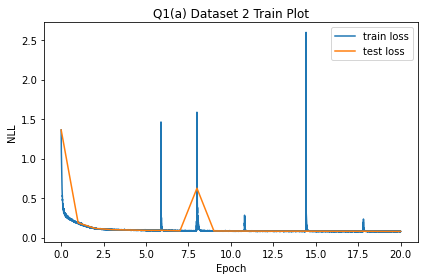

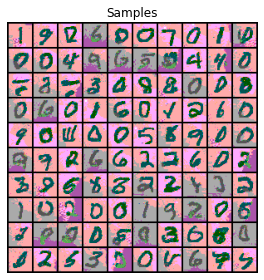

In [ ]:
q1ab_save_results(2, 'a', q1_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [13]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # x.shape = (N, C, H, W)
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, 
                        stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()
        

class ConvADependent(MaskedConv):
    def set_mask(self): 
        H, W = self.kernel_size
        in_group = self.in_channels // 3
        out_group = self.out_channels // 3

        self.mask[:, :, H // 2, :(W // 2)] = 1
        self.mask[:, :, :(H // 2)] = 1
        self.mask[out_group:(2 * out_group), :in_group, H // 2, W // 2] = 1
        self.mask[(2 * out_group):, :(2 * in_group), H // 2, W // 2] = 1

    
class ConvBDependent(MaskedConv):
    def set_mask(self):
        H, W = self.kernel_size
        in_group = self.in_channels // 3
        out_group = self.out_channels // 3

        self.mask[:, :, H // 2, :(W // 2 + 1)] = 1
        self.mask[:, :, :(H // 2)] = 1
        self.mask[:out_group, :in_group, H // 2, W // 2] = 1
        self.mask[out_group:(2 * out_group), :(2 * in_group), H // 2, W // 2] = 1
        self.mask[(2 * out_group):, :, H // 2, W // 2] = 1

In [14]:
class LayerNormDependent(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        # x.shape = (N, C, H, W)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [15]:
class ResidualDependent(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super().__init__()
        self.model = nn.Sequential(
            nn.ReLU(), 
            ConvBDependent(in_channels, in_channels // 2, 1, **kwargs), 
            nn.ReLU(), 
            ConvBDependent(in_channels // 2, in_channels // 2, 7, padding=3, **kwargs), 
            nn.ReLU(), 
            ConvBDependent(in_channels // 2, in_channels, 1, **kwargs)
        )
        
    def forward(self, x):
        # x.shape = (N, C, H, W)
        out = self.model(x)
        return out + x

In [16]:
def collate_fn(x): 
    # x.shape = (N, H, W, C)
    x = np.array(x).transpose(0, 3, 1, 2)
    x = torch.tensor(x, dtype=torch.long)
    return x 

In [37]:
class PixelCNNDependent(nn.Module):
    def __init__(self, input_shape, n_colors, n_filters=120, kernel_size=7):
        super().__init__()
        self.input_shape = input_shape
        self.n_colors = n_colors
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.model = nn.Sequential(*self.get_model())

    def get_model(self): 
        C, H, W = self.input_shape
        model = [ConvADependent(C, self.n_filters, self.kernel_size, padding=self.kernel_size // 2), 
                 LayerNormDependent(self.n_filters), 
                 nn.ReLU()]

        for _ in range(8): 
          model.extend([ResidualDependent(self.n_filters), 
                        LayerNormDependent(self.n_filters), 
                        nn.ReLU()])

        model.extend([ConvBDependent(self.n_filters, self.n_filters, 1), 
                     nn.ReLU(), 
                     ConvBDependent(self.n_filters, C * self.n_colors, 1)])
        
        return model

    def forward(self, x): 
        # x.shape = (batch_size, C, H, W)
        C, H, W = self.input_shape
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        out = self.model(x)
        # out = out.view(x.shape[0], self.n_colors, C, H, W)
        # return out
        out = out.view(x.shape[0], C, self.n_colors, H, W)
        return out.permute(0, 2, 1, 3, 4)
        
    def nll(self, x):
        logits = self(x)
        return F.cross_entropy(logits, x.long())

    def test(self, testloader):
        self.eval()
        total_loss = counts = 0

        with torch.no_grad():
            for batch in testloader:
                batch = batch.to(device)
                total_loss += self.nll(batch) * batch.shape[0]
                counts += batch.shape[0]
        
        return total_loss / counts
                
    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):
        trainloader = data.DataLoader(train_data, batch_size=batch_size, 
                                      shuffle=True, collate_fn=collate_fn)
        testloader = data.DataLoader(test_data, batch_size=batch_size,
                                     collate_fn=collate_fn)

        train_loss = []
        test_loss = []
        optimizer = optim.Adam(self.parameters(), lr=lr)
        test_loss.append(self.test(testloader))

        for epoch in tqdm(range(num_epochs), "Train epoch"):
            self.train()
            for batch in trainloader:
                loss = self.nll(batch.to(device).float())
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optimizer.step()
                train_loss.append(loss.cpu().data)

            test_loss.append(self.test(testloader))
        return train_loss, test_loss

    def sample(self, n_samples):
        self.model.eval()
        C, H, W = self.input_shape
        samples = torch.zeros(n_samples, C, H, W).to(device)

        with torch.no_grad():
            for x in range(H):
                for y in range(W):
                    for c in range(C): 
                        probs = F.softmax(self(samples), dim=1)[:, :, c, x, y]
                        samples[:, c, x, y] = torch.multinomial(probs, 1).flatten()           
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [38]:
def q1_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  H, W, C = image_shape
  model = PixelCNNDependent((C, H, W), 4, 120, 7).to(device)
  train_loss, test_loss = model.fit(train_data, test_data)
  samples = model.sample(100)
  return train_loss, test_loss, samples

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Train epoch: 100%|██████████| 20/20 [15:38<00:00, 46.94s/it]


Final Test Loss: 0.0014


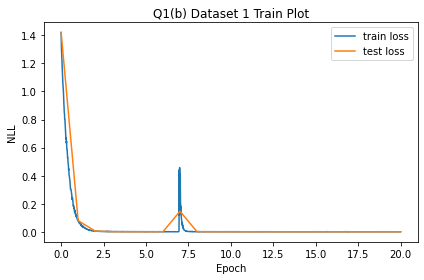

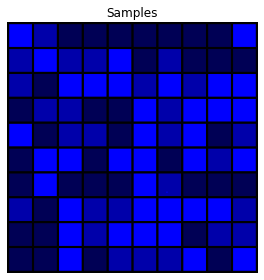

In [39]:
q1ab_save_results(1, 'b', q1_b)

Train epoch: 100%|██████████| 20/20 [15:39<00:00, 46.98s/it]


Final Test Loss: 0.0015


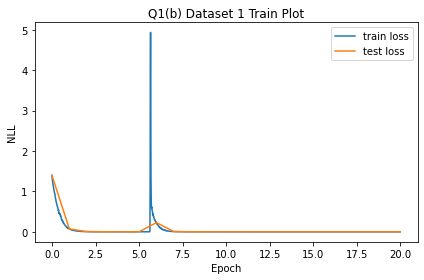

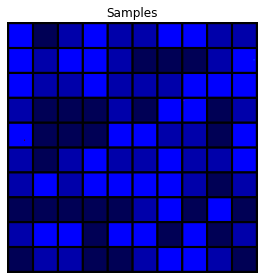

In [33]:
q1ab_save_results(1, 'b', q1_b)  # without clipping

Train epoch: 100%|██████████| 20/20 [20:04<00:00, 60.20s/it]


Final Test Loss: 0.0015


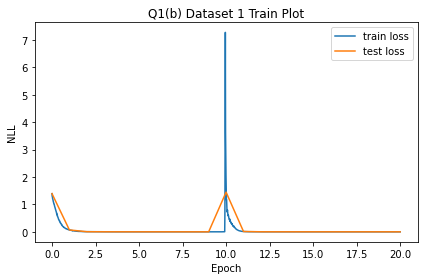

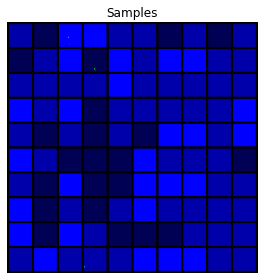

In [30]:
q1ab_save_results(1, 'b', q1_b)  # without layer norm

Train epoch: 100%|██████████| 20/20 [15:37<00:00, 46.88s/it]


Final Test Loss: 0.0014


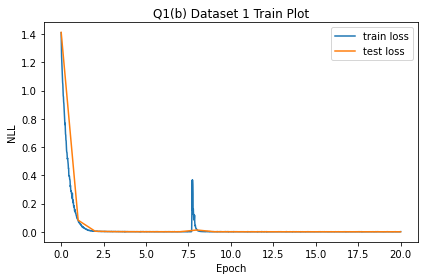

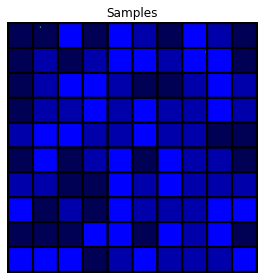

In [27]:
q1ab_save_results(1, 'b', q1_b)  # out.view(x.shape[0], C, self.n_colors, H, W)

Train epoch: 100%|██████████| 20/20 [15:35<00:00, 46.79s/it]


Final Test Loss: 0.0014


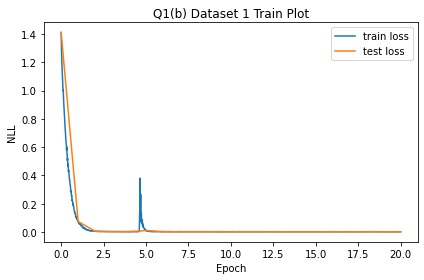

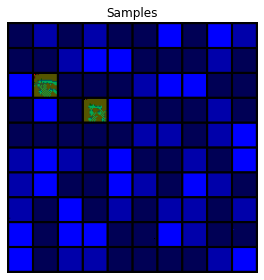

In [24]:
q1ab_save_results(1, 'b', q1_b)  # out.view(x.shape[0], self.n_colors, C, H, W)

In [ ]:
q1ab_save_results(2, 'b', q1_b)

Train epoch:   0%|          | 0/20 [01:29<?, ?it/s]


KeyboardInterrupt: ignored

## Part (c) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# you can get access to data with q1c_get_data(dset_type)

In [ ]:
class MaskedConvConditional(nn.Conv2d):
    def __init__(self, n_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.cond = nn.Linear(n_classes, self.out_channels, bias=False)
        self.set_mask()
    
    def forward(self, x, y):
        # x.shape = (N, C, H, W)
        batch_size = x.shape[0]
        out = F.conv2d(x, self.mask * self.weight, bias=self.bias, 
                       stride=self.stride, padding=self.padding)
        cond_out = self.cond(y)
        out += cond_out.view(batch_size, -1, 1, 1)
        return out

    def set_mask(self):
        raise NotImplementedError()

In [ ]:
class ConvAConditional(MaskedConvConditional):
    def set_mask(self): 
        H, W = self.kernel_size
        self.mask[:, :, H // 2, :(W // 2)] = 1
        self.mask[:, :, :(H // 2)] = 1

    
class ConvBConditional(MaskedConvConditional):
    def set_mask(self):
        H, W = self.kernel_size
        self.mask[:, :, H // 2, :(W // 2 + 1)] = 1
        self.mask[:, :, :(H // 2)] = 1

In [ ]:
class LayerNormConditional(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x, y):
        # x.shape = (N, C, H, W)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [ ]:
class ReLUConditional(nn.ReLU):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x, y):
    x = super().forward(x)
    return x

In [ ]:
class ResidualConditional(nn.Module):
    def __init__(self, n_classes, in_channels, **kwargs):
        super().__init__()
        self.model = nn.ModuleList([
            ReLUConditional(), 
            ConvBConditional(n_classes, in_channels, in_channels // 2, 1, **kwargs), 
            ReLUConditional(), 
            ConvBConditional(n_classes, in_channels // 2, in_channels // 2, 7, 
                             padding=3, **kwargs), 
            ReLUConditional(), 
            ConvBConditional(n_classes, in_channels // 2, in_channels, 1, **kwargs)
        ])
        
    def forward(self, x, y):
        # x.shape = (N, C, H, W)
        out = x
        for layer in self.model:
            out = layer(out, y)
            
        return out + x

In [ ]:
class PixelCNNConditional(nn.Module):
    def __init__(self, input_shape, n_colors, n_classes,
                 n_filters=120, kernel_size=7):
        super().__init__()
        self.input_shape = input_shape
        self.n_channels = input_shape[0]
        self.n_colors = n_colors
        self.n_classes = n_classes
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.model = nn.ModuleList(self.get_model())

    def get_model(self): 
        C, H, W = self.input_shape
        model = [ConvAConditional(self.n_classes, C, self.n_filters, 
                                  self.kernel_size, padding=self.kernel_size // 2), 
                 LayerNormConditional(self.n_filters), 
                 ReLUConditional()]

        for _ in range(8): 
          model.extend([ResidualConditional(self.n_classes, self.n_filters), 
                        LayerNormConditional(self.n_filters), 
                        ReLUConditional()])

        model.extend([ConvBConditional(self.n_classes, self.n_filters, self.n_filters, 1), 
                      ReLUConditional(), 
                      ConvBConditional(self.n_classes, self.n_filters, C * self.n_colors, 1)])
        
        return model

    def forward(self, x, y): 
        # x.shape = (batch_size, C, H, W)
        y = y.float()
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        out = x
        for l in range(len(self.model)):
            out = self.model[l](out, y)

        return out.view(x.shape[0], self.n_channels, self.n_colors, 
                        *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
        
    def nll(self, x, y):
        logits = self(x, y)
        return F.cross_entropy(logits, x.long())

    def test(self, testloader):
        total_loss = counts = 0

        with torch.no_grad():
            for (batch_x, batch_y) in testloader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                total_loss += self.nll(batch_x, batch_y) * batch_x.shape[0]
                counts += batch_x.shape[0]
        
        return total_loss / counts
                
    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):
        trainloader = data.DataLoader(train_data, batch_size=batch_size, 
                                      shuffle=True)
        testloader = data.DataLoader(test_data, batch_size=batch_size)

        train_loss = []
        test_loss = []
        optimizer = optim.Adam(self.parameters(), lr=lr)
        test_loss.append(self.test(testloader))

        for epoch in tqdm(range(num_epochs), "Train epoch"):
            for (batch_x, batch_y) in trainloader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                loss = self.nll(batch_x, batch_y)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optimizer.step()
                train_loss.append(loss.cpu().data)

            test_loss.append(self.test(testloader))
        return train_loss, test_loss

    def sample(self, n_samples, labels):
        self.model.eval()
        samples = torch.zeros(n_samples, *self.input_shape).to(device)
        C, H, W = self.input_shape

        with torch.no_grad():
            for x in range(H):
                for y in range(W):
                    for c in range(C): 
                        logits = self(samples, labels)[:, :, c, x, y]
                        probs = F.softmax(logits, dim=1)
                        samples[:, c, x, y] = torch.multinomial(probs, 1).squeeze(-1)             
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [ ]:
class SimpleDataset(data.Dataset):
  def __init__(self, x, y, n_classes):
      super().__init__()
      self.x = np.transpose(x, (0, 3, 1, 2))
      self.y = np.zeros((len(y), n_classes))
      self.y[np.arange(len(y)), y] = 1

  def __len__(self):
      return len(self.x)

  def __getitem__(self, index):
      return self.x[index], self.y[index]

In [ ]:
def q1_c(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """

  train_dataset = SimpleDataset(train_data, train_labels, n_classes)
  test_dataset = SimpleDataset(test_data, test_labels, n_classes)

  H, W = image_shape
  model = PixelCNNConditional((1, H, W), 2, n_classes, 120, 7).to(device)

  train_losses, test_losses = model.fit(train_dataset, test_dataset, num_epochs=10, lr=1e-3)
  
  labels = np.repeat(np.arange(n_classes), 100 // n_classes)
  labels_tensor = torch.zeros(100, n_classes, dtype=torch.float).to(device)
  labels_tensor[np.arange(100), labels] = 1

  samples = model.sample(100, labels_tensor)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q1_c`, execute the cells below to visualize and save your results



Train epoch: 100%|██████████| 10/10 [07:42<00:00, 46.28s/it]


Final Test Loss: 0.0328


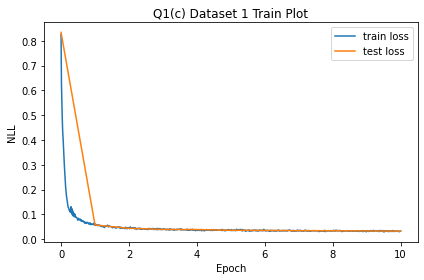

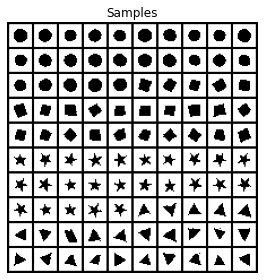

In [ ]:
q1c_save_results(1, q1_c)

In [ ]:
q1c_save_results(2, q1_c)

Train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

# Bonus 1: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
#b1ab_get_data()

In [ ]:
def b1_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_a`, execute the cells below to visualize and save your results



In [ ]:
b1a_save_results(b1_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b1_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_b`, execute the cells below to visualize and save your results



In [ ]:
q1b_save_results(q1_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
#b1c_get_data()

In [ ]:
def b1_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `b1_c`, execute the cells below to visualize and save your results



In [ ]:
b1c_save_results(b1_c)